# **Movie Recommender using K-Means Clustering**


In this project I am going to introduce how to create a basic **Movie Recommendation** engine using the **K-Means Clustering** technique. The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.  

K-means was employed to cluster users according to their ratings of movies they have seen. Thus, each cluster will contain a group of users with similar taste in movies. The movie recommender will work by recommending a list Top 10 movies not seen by a selected user. The list of movies will be sorted by the average rating of a movie by users in the same cluster.

In [2]:
#import modules

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#column headers for the dataset
data_cols = ['userid','movieid','rating','timestamp']
item_cols = ['movieid','movietitle','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
'Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance ','Sci-Fi','Thriller',
'War' ,'Western']

#read files
data = pd.read_csv('u.data', sep='\t', names=data_cols, encoding='latin-1')
movies = pd.read_csv('u.item', sep='|', names=item_cols, encoding='latin-1')
movies = movies[['movieid','movietitle']]


## **Data Preparation**

The ratings dataset for each movies would be used to build the recommendation engine. Before it can be plugged into the Kmeans algorithm it has to go through a couple transformation step.

#### 1.   **Reshaping the Data**
> For Kmeans user based clustering we want the data to be in an user-movie array, where each row is a different user with ratings for different movies and each column is a specific movie. To reshape the dataframe, we'll use the pandas pivot function. 

#### 2.   **Dealing with missing values** 

> By reshaping the data to a matrix we end up with a lot of missing data because not every user has seen every movie and we can't get rid of rows containin nulls because we would end up with no data. So the nulls will be replaced with 0s










In [3]:
#pivot data movies in rows, user in columns
df_matrix = data.pivot(
    index='userid',
    columns='movieid',
    values='rating'
).fillna(0)
df_matrix.head()

#convert the df into a numpy array for efficient processing
cluster_data = df_matrix.values



## **How many Clusters?**

With clustering there is no need to train and test the model however a key consideration is how many clusters should there be on your model. When fitting models, it is possible to increase the model performance by adding parameters, in this case adding more clusters, but doing do so may result in overfitting.

A means of correcting for over-fitting and deciding on how many clusters is by using the k-means inertia graph. Inertia measures how far samples are from the center of the cluster (centriod). The lower the inertia the better the cluster.

The general rule is to select a clusters around the elbow of the inertia plot which, is the point where the inertia begins to decrease more slowly. 

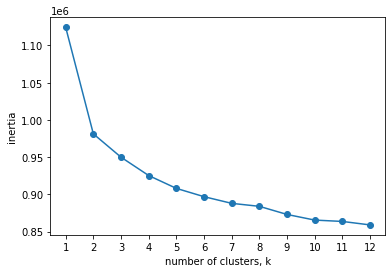

In [4]:
#finding optimal K

#Step 1 - import KMeans
from sklearn.cluster import KMeans


#Step 2 - initiate the number of times we want to run the Kmeans cluster (12)
ks = range(1, 13)
inertias = []

#Step 3 - Run the K-means cluster for 1 to 12 clusters and append the inertia to list
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(cluster_data)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
#Step 4 - Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## **Build the Model**  

With the optimal K selected lets build our model

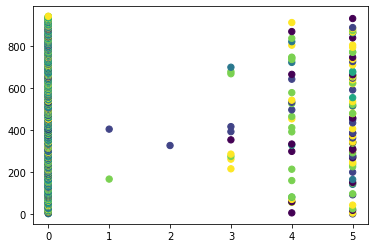

In [5]:
model = KMeans(n_clusters = 6)
model.fit(cluster_data)
labels = model.predict(cluster_data)
centriods = model.cluster_centers_
xs = cluster_data[:,168]
ys = range(0,len(cluster_data))
plt.scatter(xs, ys, c=labels, s=40, cmap='viridis', zorder=3)
plt.show()

A spread of the cluster for the movie 'The English Patient'

## **Build the Recommendation Engine**  

#### 1.   **Extract user cluster labels**

In [6]:
#put labels and users in a dataframe
df = pd.DataFrame(cluster_data)
df['cluster label'] = labels
print(df['cluster label'].value_counts())

df1 = df[['cluster label']]
df1['userid'] = df1.index + 1

2    300
3    200
4    179
5    142
1     65
0     57
Name: cluster label, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### 2.   **Merge Cluster labels to the ratings and movie dataset**

In [8]:
#merge cluster labels and movies into the data frame
df3 = pd.merge(pd.merge(data,df1),movies)
df3.drop(['timestamp','movieid'], axis=1, inplace=True)


#### 3.   **Create a dataframe to store average movie rating for each Cluster**

In [9]:
cluster_grouped = df3.groupby(['cluster label','movietitle'])['rating'].agg(['mean','count']).reset_index()
cluster_grouped[cluster_grouped['movietitle'] == 'Young Frankenstein (1974)']

,cluster label,movietitle,mean,count
1287,0,Young Frankenstein (1974),4.113636,44
2732,1,Young Frankenstein (1974),4.179487,39
3840,2,Young Frankenstein (1974),3.750000,4
4931,3,Young Frankenstein (1974),2.750000,8
6081,4,Young Frankenstein (1974),3.883721,43
7374,5,Young Frankenstein (1974),3.887097,62


#### 4.   **Initiate the recommendation function**


In [22]:
def recommender(id):

  #distinct list of movies
  movieList = list(df3['movietitle'].unique())
  #extract movies seen and notSeen by user
  user_d = df3[df3['userid'] == id]
  seen = list(user_d['movietitle'].unique())
  notSeen = list(set(movieList)-set(seen))
  #obtain user cluster
  uCluster = user_d['cluster label'].iloc[0]
  
  #filter cluster grouped by uCluster and not seen
  recos = cluster_grouped[~(cluster_grouped['movietitle'].isin(notSeen)) & (cluster_grouped['cluster label']==uCluster)]
  recos = recos[['movietitle','mean','count']].sort_values('mean', ascending=False).iloc[:10].reset_index()
  return recos




#### 4.   **Retrieve Recommendations**  

*Pass in the user id to the recommender function to retrieve top ten recommendations*

In [24]:
rec = recommender(621)
print("Your Top 10 Recommendations are:")
print("_"*110)
for i, r in rec.iterrows():
  print("{0}. {1} - watched by {2} similar users with an average rating of {3:.1f}".format(i+1, r['movietitle'], r['count'], r['mean']))


Your Top 10 Recommendations are:
______________________________________________________________________________________________________________
1. Star Wars (1977) - watched by 131 similar users with an average rating of 4.4
2. Raiders of the Lost Ark (1981) - watched by 130 similar users with an average rating of 4.4
3. Princess Bride, The (1987) - watched by 103 similar users with an average rating of 4.3
4. Empire Strikes Back, The (1980) - watched by 124 similar users with an average rating of 4.2
5. Titanic (1997) - watched by 50 similar users with an average rating of 4.2
6. Chasing Amy (1997) - watched by 42 similar users with an average rating of 4.1
7. Searching for Bobby Fischer (1993) - watched by 39 similar users with an average rating of 4.1
8. Apollo 13 (1995) - watched by 91 similar users with an average rating of 4.1
9. Return of the Jedi (1983) - watched by 127 similar users with an average rating of 4.1
10. Fugitive, The (1993) - watched by 108 similar users with an a